In [103]:
import tensorflow as tf
import os

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [104]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [106]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [107]:
import numpy as numpy
import matplotlib.pyplot as plt
import os

In [108]:
data=tf.keras.utils.image_dataset_from_directory('data',shuffle=False)

Found 4000 files belonging to 8 classes.


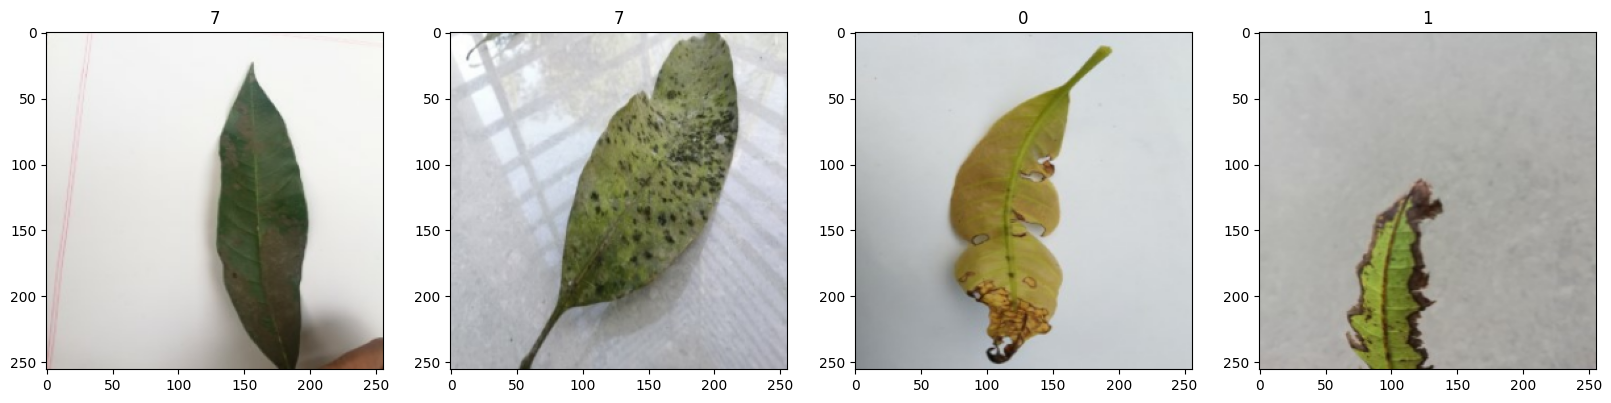

In [6]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

The tensorflow image dataset from directory loads each directory images into a different class, which is desired for us as well. It assings the classes by alphanumeric order of directory names. To see which class refers to which number we can do the following:

In [7]:
class_names = data.class_names
for i in range(len(class_names)):
    print(f'The {i}th class name is: {class_names[i]}')

The 0th class name is: Anthracnose
The 1th class name is: Bacterial Canker
The 2th class name is: Cutting Weevil
The 3th class name is: Die Back
The 4th class name is: Gall Midge
The 5th class name is: Healthy
The 6th class name is: Powdery Mildew
The 7th class name is: Sooty Mould


In [34]:
#Scale our data as images contains 0-255 values
#Luckily the tensorflow image dataset load method includes map method as well
scale_data=data.map(lambda x,y: (x/255,y))
img_shape=data.element_spec[0].shape[1:]
class_count=len(data.class_names)

## Creating train, validation and test groups

In [9]:
len(data)

125

Our data has 125 batches. We will use %70 train %20 validation and %10 test split.

In [10]:
train_split=int(len(data)*.7)
validation_split=int(len(data)*.2)
test_split=len(data)-train_split-validation_split

In [11]:
#Check total batch numbers in splits and if our total split batch number equals back to 125:
print(train_split)
print(validation_split)
print(test_split)
print(train_split+validation_split+test_split)

87
25
13
125


In [17]:
#And now lets assign data batches to groups:
train=scale_data.take(train_split)
validation=scale_data.skip(train_split).take(validation_split)
test=scale_data.skip(train_split+validation_split).take(test_split)

In [120]:
#Checking our dataset for train. It can be noted the shape is 256,256,3, which will be our input configuration
type(train)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [36]:
# we will use efficientnetb0 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

In [64]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(8, activation= 'softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# model=Sequential()
# model.add(Conv2D(16,(3,3), 1, activation='relu',input_shape=(256,256,3)))
# model.add(MaxPooling2D())
# model.add(Conv2D(32, (3,3),1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(16, (3,3),1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(8, activation='softmax'))
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization_5 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 256)               327936    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 4,384,683
Trainable params: 4,340,100
Non-trainable params: 44,583
_______________________________________

In [66]:
logdir='logs'

In [67]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [69]:
hist = model.fit(train, epochs=4, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/4
87/87 [==============================] - 394s 5s/step - loss: 1.5727 - accuracy: 0.9964 - val_loss: 0.7987 - val_accuracy: 0.9987
Epoch 2/4
87/87 [==============================] - 361s 4s/step - loss: 0.5622 - accuracy: 0.9957 - val_loss: 0.3637 - val_accuracy: 0.9925
Epoch 3/4
87/87 [==============================] - 355s 4s/step - loss: 0.3888 - accuracy: 0.9917 - val_loss: 0.3983 - val_accuracy: 0.9912
Epoch 4/4
87/87 [==============================] - 383s 4s/step - loss: 0.3400 - accuracy: 0.9928 - val_loss: 0.3417 - val_accuracy: 0.9962


In [101]:
loss, accuracy = model.evaluate(test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

13/13 [==============================] - 43s 2s/step - loss: 0.3415 - accuracy: 0.9976
Test loss: 0.3414880335330963
Test accuracy: 0.9975961446762085


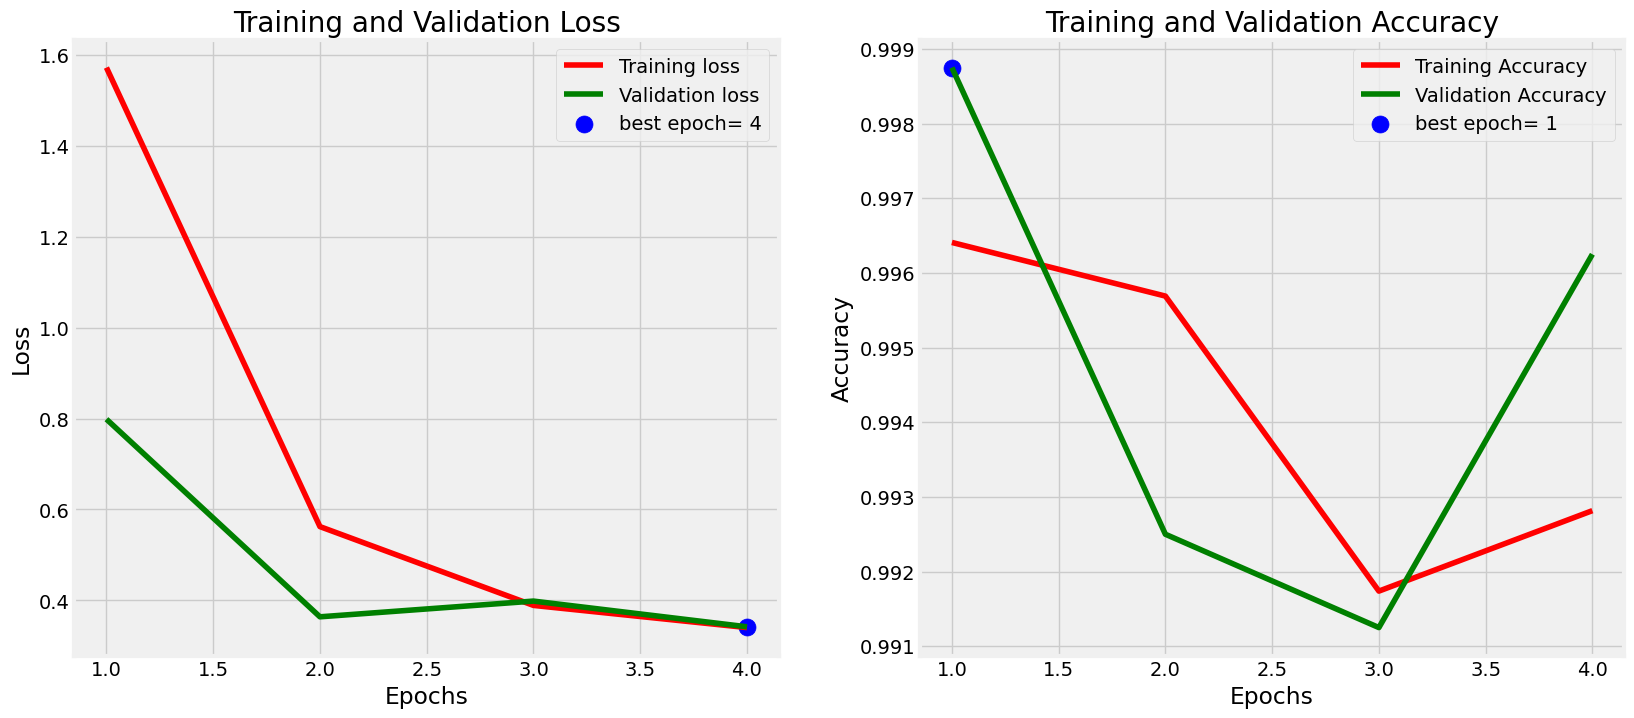

In [74]:
import numpy as np

# Define needed variables
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [122]:
import numpy as np

def dataset_to_numpy(test):
    all_images = []
    all_labels = []
    
    for images, labels in test:
        # `.numpy()` converts TensorFlow tensors to NumPy arrays
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())
    
    # Use `np.concatenate` to merge the list of arrays into one array
    all_images_np = np.concatenate(all_images, axis=0)
    all_labels_np = np.concatenate(all_labels, axis=0)
    
    return all_images_np, all_labels_np

# Assuming `test` is your TensorFlow test dataset
test_images_np, test_labels_np = dataset_to_numpy(test)


In [123]:
preds_np = model.predict(test_images_np)

13/13 [==============================] - 40s 3s/step


In [129]:
y_pred = np.argmax(preds_np, axis=1)

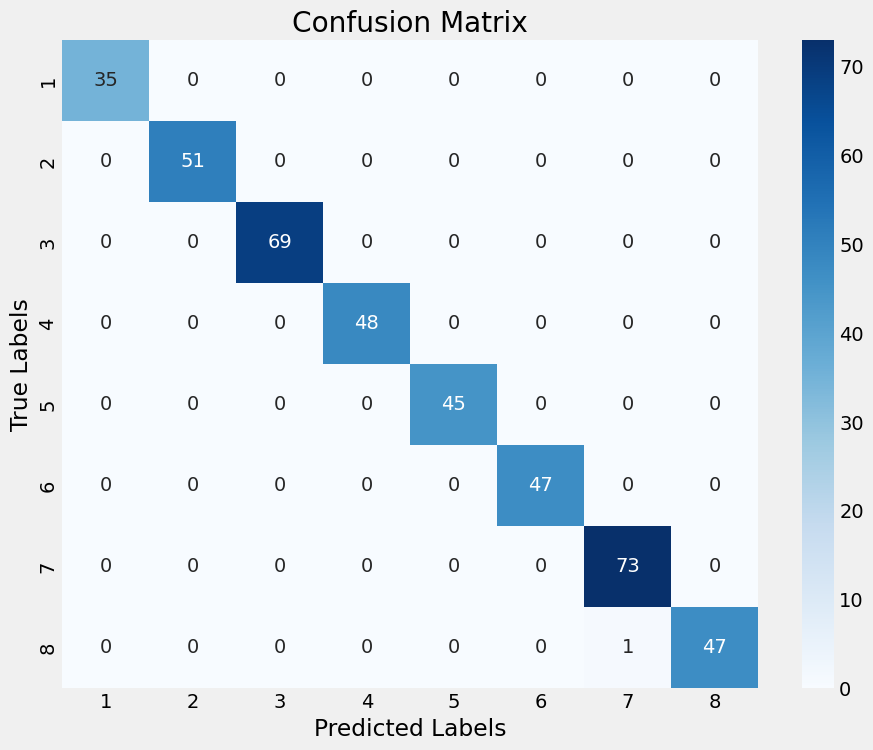

In [128]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure true_labels is a NumPy array for compatibility

conf_matrix = confusion_matrix(test_labels_np, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [70]:
save_path = 'model/'

# Save model
save_id = 'efficientnetb3-MangoDiseaseClassifier.h5'
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = 'efficientnetb3-MangoDiseaseClassifier-weights.h5'
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [130]:
# For saving the model in SavedModel format
model_save_loc = os.path.join(save_path, 'efficientnetb3-MangoDiseaseClassifier')
model.save(model_save_loc, save_format='tf')
print(f'Model was saved as {model_save_loc}')

INFO:tensorflow:Assets written to: model/efficientnetb3-MangoDiseaseClassifier\assets


INFO:tensorflow:Assets written to: model/efficientnetb3-MangoDiseaseClassifier\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.